# Regularization

Our car parking example is a bit contrived, but it illustrates a core principle at the heart of good model selection: *if we have useful prior knowledge about the domain, we should pick an estimator that builds that knowledge into its assumptions*. For example, if we have a set of 1,000 potential features we could use in our model, but have good reason to believe that only a small fraction of those features make a meaningful contribution to the outcome variable, it seems like a good idea to pick an estimator that can somehow *select* a subset of features. Using an estimator that acts as if all of our features are potentially important (as linear regression does) is likely to lead to overfitting.

The principle of introducing background knowledge into our model in order to improve predictions and prevent overfitting is known in machine learning and statistics as *regularization*. When we say we're using a regularized estimator, what we're typically saying is that we've taken an existing estimator (e.g., an OLS estimator) and constrained it with additional information some way, so that it's *biased* towards certain parts of the parameter space.

<small>(A quick side note: Readers familiar with Bayesian analysis may at this point be thinking, *hey, this sounds a lot like the rationale for using priors in Bayesian statistical analysis*. This isn't a coincidence! Conceptually, regularization achieves the same objective as Bayesian priors, and many forms of regularization can be formalized equivalently in terms of prior distributions over model parameters.)</small>

# Penalized regression

If you're coming from a biomedical or social science background, it may be tempting to think of least-squares estimation as a kind of automatic default, with all other procedures requiring some special justification to use. But there's nothing terribly special about OLS. Well, it's special in that it always minimizes the squared error in our training sample. But as we've already seen, we usually care about minimizing test error, not training error (plus, sometimes we don't want to quantify error in terms of a least-squares criterion). So if we can get our hands on an estimator that's biased with respect to OLS, but tends to reduce error in the *test* dataset, we probably still want to use it—even if it doesn't reduce error in the *training* data quite as well as OLS.

Fortunately for us, there are many, many such estimators. One of the most widely used class of estimators for regression problems is *penalized regression*. These methods generally begin with garden variety OLS, and then add a little twist in the form of a *penalty* parameter.

Consider the cost function we seek to minimize in OLS:

$Cost = RSS = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2$

Here, $RSS$ is the residual sum of squares, $N$ is the number of samples, and $P$ is the number of features. Our goal is to obtain the set of $\beta$ coefficients that minimize the $RSS$.

Now consider a slight variation:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \lambda\sum^P_j|\beta_j|$

The only difference here is that, in addition to the $RSS$, our cost function includes a second term, $ \lambda\sum^P_j|\beta_j|$—the sum of absolute values of the $\beta$ coefficients, weighted by the *penalty* parameter $\lambda$.The addition of the penalty parameter is the reason we refer to this variation on linear regression as penalized regression. The addition of the penalty may seem like a small change, but it has major consequences, which we'll explore shortly.

The above form of penalized regression is known as [*lasso regression*](https://en.wikipedia.org/wiki/Lasso_(statistics)), and it's very widely used. There's also another very common form of penalized regression known as [*ridge regression*](https://en.wikipedia.org/wiki/Tikhonov_regularization). It looks a lot like lasso regression, except instead of computing the penalty as the sum of absolute coefficients, we take their squared sum:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \lambda\sum^P_j\beta_j^2$

The difference between lasso and ridge regression may seem even smaller, but it again has important implications. Let's explore the behavior of each of these methods.

# Lasso regression

Let's take the lasso first. Let's think about what the addition of the penalty term to the standard RSS criterion does, conceptually. By making the overall cost depend on a (weighted) sum of absolute coefficients, we're basically saying that there's a certain cost to having large coefficients in our model. If the net negative contribution of a given feature to the RSS is smaller than its net positive contribution to the penalty, then it will be beneficial to "shrink" that feature's coefficient to the point where the two terms perfectly cancel each other out. Thus, penalized regression *biases* the estimated regression coefficients by shrinking at least some of them.

For reasons outside the scope of this tutorial (see Figure 1 of [this paper](https://www.stat.cmu.edu/~larry/=sml/sparsity.pdf)), the lasso doesn't just shrink coefficients; it actually shrinks them all the way to zero. That is, as we increase the penalty, more features drop out of our model, leaving us with a simpler prediction equation involving fewer features. For this reason, the lasso is often described as implicitly included a *feature selection* step (we'll come back to this idea of feature selection in Section 6).

To see how this works in practice, let's return to our personality data and visualize what happens to our regression coefficients estimated with lasso regression as we increase the penalty parameter. We'll write a little helper to plot *coefficient paths*...

In [4]:
def plot_coef_path(estimator, X, y, alpha, ax=None):
    if ax is None:
        ax = plt.figure().gca()
    coefs = np.zeros((X.shape[1], len(alpha)))
    for (i, a) in enumerate(alpha):
        coefs[:,i] = estimator(alpha=a).fit(X, y).coef_
    ax.plot(alpha, coefs.T)
    ax.set_xlabel("Penalty (alpha)")
    ax.set_ylabel("Coefficient value")
    ax.set_xscale('log')

...and now we'll apply it to our data, judiciously picking a reasonable range of $\lambda$ values.

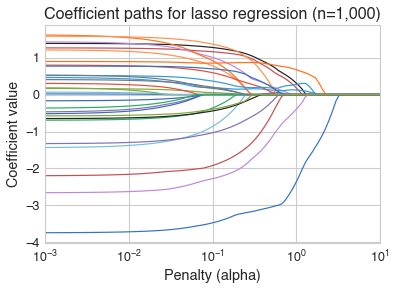

In [5]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

facets, age = get_features(data, 'facets', 'AGE', n=1000)

# Note: we standardize our features to mean-zero and unit-variance,
# because lasso and ridge are sensitive to scale.
facets = scale(facets)

# Coefficient paths for ridge regression, predicting age from 30 facets
alpha = np.logspace(-3, 1, 100)
plot_coef_path(Lasso, facets, age, alpha)

plt.title("Coefficient paths for lasso regression (n=1,000)", fontsize=16)
plt.xlim(1e-3, 10);

Here, each colored line represents a different feature. We're using the 30 facets as our predictors, so there are thirty lines. The x-axis displays the penalty parameter used for lasso estimation; the y-axis displays the resulting value of the coefficients. Notice how, at a certain point (around `alpha = 0.1`), coefficients start to disappear. They're not just small; they're *gone*. This built-in feature selection is a very useful property of the lasso. It allows us to achieve an arbitrarily sparse solution simply by increasing the penalty.

Of course, as you know by now, *there's no free lunch in machine learning*. There must be some price we pay for the interpretability of the lasso solution, right? There is. We'll look at it in a moment; but first, let's talk about ridge regression.

# Ridge regression

Ridge regression, as noted above, is mathematically very similar to lasso regression. But it behaves very differently. Whereas the lasso produces sparse solutions, ridge regression, like OLS, always produce dense ones. Ridge *does* still shrink the coefficients (i.e., their absolute values get smaller as the penalty increases). It also pushes them towards a normal distribution (in fact—for readers with a Bayesian statistics background—ridge regression is equivalent to imposing a normal hyperprior over all coefficients). The latter property is the reason a well-tuned ridge regression model usually outperforms OLS: you can think of ridge regularization as basically a way of saying *hey, even though it may **look** like a few of the OLS coefficients are way bigger than others, that's probably just because we're overfitting noise. So let's squash all of the extreme values towards zero a bit, so that all of our coefficients are relatively small and bunched together.*

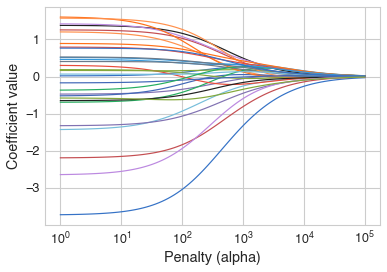

In [6]:
from sklearn.linear_model import Ridge

# Coefficient paths for ridge regression, predicting age from 30 facets
alpha = np.logspace(0, 5, 100)
plot_coef_path(Ridge, facets, age, alpha)

It may *look* like the coefficients are shrinking all the way to zero here, but they aren't. They're just getting really, really small.

# Effects of regularization on predictive performance

We've looked at two different flavors of penalized regression, and established that they behave quite differently. So, which one should we use? Which is the *better* regularization approach? Well, as with everything else—and stop me if you've heard this one before—*it depends*. If the process(es) that generated our data are sparse (or at least, have a good sparse approximation)—meaning, a few of our features make very large contributions, and the result don't much matter—then lasso regression will tend to perform better. If the data-generating process is dense—i.e., lots of factors make small contributions to the outcomes—then ridge regression will tend to perform better.

In practice, we almost never know the ground truth when working with empirical data. So we're forced to rely on a mix of experience, intuition, and validation analyses.

Let's do some of the latter here. To try to figure out what the optimal lasso and ridge penalties are for our particular problem, we'll make use of scikit-learn's `validation_curve` utility, which allows us to quickly generate training and testing performance estimates for an estimator as a function of one of its parameters. As alluded to in Section 4, the `validation_curve` is very similar to the `learning_curve` we've seen repeatedly, except that instead of systematically varying the dataset size, we systematically vary one of the estimator's parameters (in this case, `alpha`).

First, let's write a plotting function we can reuse.

In [7]:
def plot_train_test(x_range, train_scores, test_scores, label, hlines=None):
    plt.plot(x_range, train_scores.mean(1), label=f'{label} (train)')
    plt.plot(x_range, test_scores.mean(1), label=f'{label} (test)')
    plt.grid(axis='y', linestyle='--')
    plt.xscale('log')
    plt.ylabel('$R^2$', fontsize=14)
    plt.xlabel('Penalty (alpha)', fontsize=14)
    plt.ylim(0, 1)

    if hlines:
        for lab, line in hlines.items():
            plt.hlines(line, x_range.min(), x_range.max(), linestyles='--', label=lab)

    plt.legend(fontsize=14)

Now let's generate a validation curve for lasso regression, holding sample size constant at 1,000, and using the 300 items to predict age.

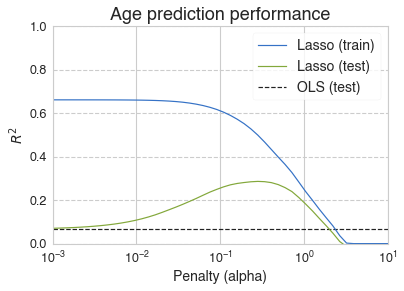

In [8]:
from sklearn.model_selection import validation_curve

items, age = get_features(data, 'items', 'AGE', n=1000)

x_range = np.logspace(-3, 1, 50)
train_scores, test_scores = validation_curve(Lasso(), items, age, 'alpha', x_range, cv=5,
                                             scoring='r2')

# Add OLS R^2 for reference
ols_r2 = cross_val_score(LinearRegression(), items, age, scoring='r2', cv=5).mean()

plot_train_test(x_range, train_scores, test_scores, 'Lasso', hlines={'OLS (test)': ols_r2})
plt.title("Age prediction performance", fontsize=18)
plt.xlim(1e-3, 10);

Notice that, in the training dataset, $R^2$ decreases monotonically as alpha increases. This is necessarily true. Why? (*Hint*: think of how $R^2$ is defined, and its relationship to the least-squares component of the lasso cost function.)

In contrast, the error in the test dataset is lowest within a specific range of `alpha` values. This optimum will vary across datasets, so you'll almost always need to tune the alpha parameter (e.g., using a validation curve like the one above) to get the best performance out of your model. This extra degree of complexity in the estimation process is one of the reasons you might *not* want to opt for a penalized version of OLS, even if you think it'll probably improve your predictions somewhat. If you muck things up and pick the wrong penalty, your predictions could be way worse than OLS!

Let's do the same thing, but this time for ridge regression. Note that the range of alpha values that work best changes pretty dramatically.

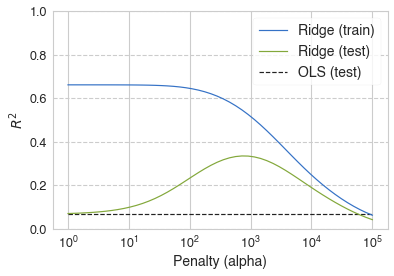

In [9]:
x_range = np.logspace(0, 5, 50)
train_scores, test_scores = validation_curve(Ridge(), items, age, 'alpha', x_range, cv=5,
                                             scoring='r2')
plot_train_test(x_range, train_scores, test_scores, 'Ridge', hlines={'OLS (test)': ols_r2})

Like lasso regression, ridge regression outperform OLS in the test data—but only within a certain range of penalty values, once again illustrating the bias variance tradeoff (i.e., introducing the *right* bias will help us, but if we're wrong, we would have been better off with a less biased, higher-variance approach).

While we've only looked at one dataset, these are fairly typical results; in many application domains, penalized regression models tend to outperform OLS when using small to moderate-sized samples. When samples get very large relative to the number of features, the performance difference usually disappears (as you can verify by re-running the above cells with a larger *n*). Outside of domains with extremely structured and high-dimensional data, this latter principle tends to be true more globally—i.e., "more data usually beats better algorithms."

# Other methods

We've focused our attention here on lasso and ridge regression because they're regularized versions of the OLS estimator most scientists are already familiar with. But just as there's nothing special about OLS, there's also nothing special about (penalized) regression in general. There are many different estimators we could use to generate predictions. Each has its own inductive biases, and will perform better on some datasets and worse on others. The science (or is it an art?) of machine learning lies in understanding the available estimators, data, and validation methods well enough to know how to select and train optimal (or at least good) estimators given the problem in question.

Out of the box, scikit-learn supports hundreds of different regression and classification methods. Here's a very popular flowchart by sklearn core contributor [Andreas Mueller](https://datascience.columbia.edu/andreas-mueller) that can help identify good candidate estimators for one's problem:

![sklearn flowchart](https://scikit-learn.org/stable/_static/ml_map.png)